        Date  WTI-Spot-Price
0 1986-01-02           25.56
1 1986-01-03           26.00
2 1986-01-06           26.53
3 1986-01-07           25.85
4 1986-01-08           25.87


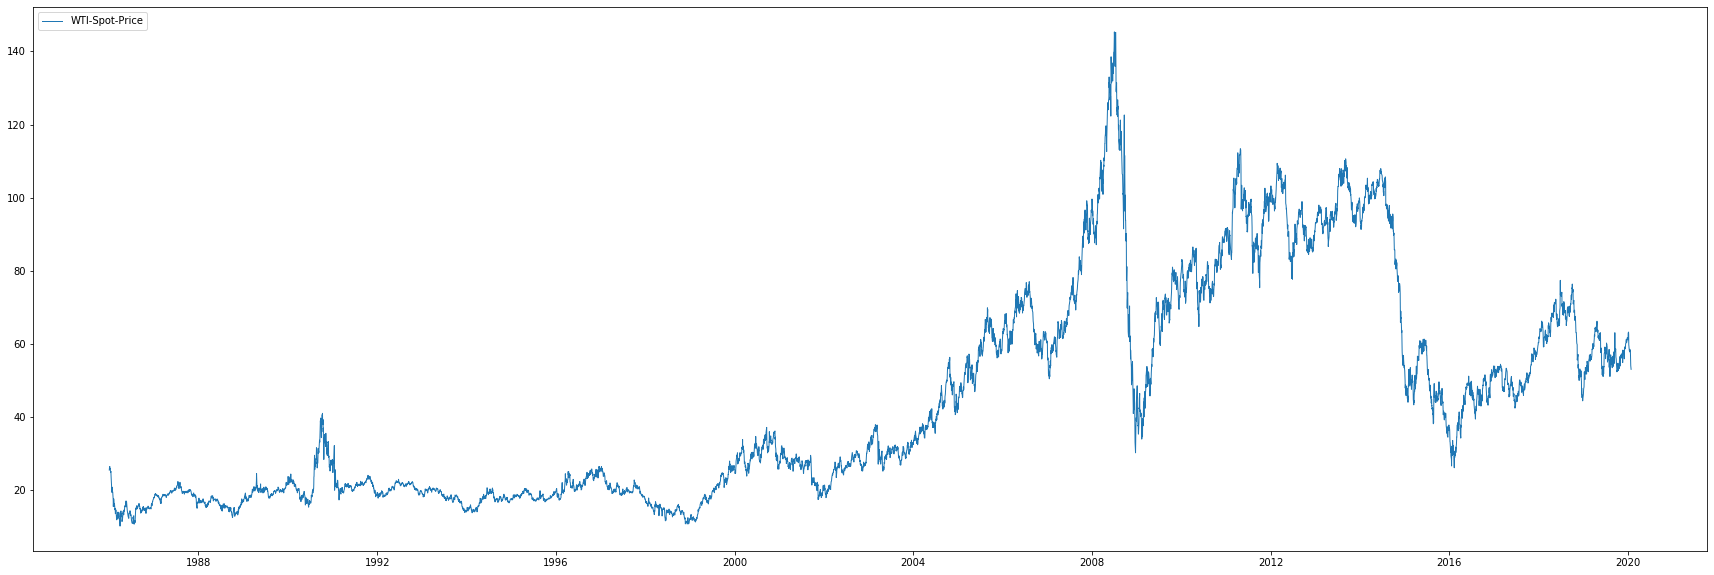

In [7]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from math import sqrt
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt   # Import matplotlib
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import merge, Input, concatenate, average, add
from keras.layers.recurrent import LSTM, GRU
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from sklearn.metrics import r2_score

data=pd.read_excel(r'F:/研究生阶段/毕业设计/RWTCd.xls',sheet_name='s')
'''
先对imf1进行预测
'''
print(data.head())

data1=data[['Date','WTI-Spot-Price']]
data2=data[['Date','WTI-Spot-Price']].set_index('Date')
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(data1['Date'],data1['WTI-Spot-Price'],linestyle='-',linewidth=1,label='WTI-Spot-Price')
plt.legend(loc='upper left')

In [8]:
'''
最大最小归一化数据
'''
from sklearn.preprocessing import MinMaxScaler
x_train=data2['1986-1-2':'2008-3-31'].values
x_test=data2['2008-4-1':'2013-10-21'].values
min_max_scaler=MinMaxScaler()
x_train_scale=min_max_scaler.fit_transform(x_train)
x_test_scale=min_max_scaler.transform(data2['2008-4-1':'2013-10-21'])
print(x_test_scale)
print(x_train_scale)

[[0.90706283]
 [0.94617847]
 [0.93707483]
 ...
 [0.90506202]
 [0.90656263]
 [0.89065626]]
[[0.15316126]
 [0.15756303]
 [0.16286515]
 ...
 [0.9734894 ]
 [0.95378151]
 [0.91326531]]


In [9]:
def build_timeseries(mat, y_col_index, TIME_STEPS):
    # y_col_index 是作为输出列的列号
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS #number of time-series samples 
    dim_1 = mat.shape[1]# number of features
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(0,dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]#‘y_col_index’ is the index of your output column
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [10]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size 
    #here the input 'mat' should be the overall input time series data which has already been devided into windows 
    #这里的mat应该是已经被划分时间窗口的总体的时间序列数据
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [11]:
BATCH_SIZE=10
TIME_STEPS=1
epoch=50
# lr=0.01
x_t, y_t = build_timeseries(x_train_scale,0, TIME_STEPS)#data for train
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test_scale,0,TIME_STEPS)# x_temp contains the data for validation as well as for test
x_test=trim_dataset(x_temp, BATCH_SIZE)
y_test=trim_dataset(y_temp, BATCH_SIZE)

length of time-series i/o (5611, 1, 1) (5611,)
length of time-series i/o (1402, 1, 1) (1402,)


In [12]:
from keras import optimizers
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
# import os
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
# OUTPUT_PATH="F:\\研究生阶段\\机器学习\\深度学习\\LSTM实现"
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

# history = lstm_model.fit(x_t, y_t, epochs=epoch, verbose=2, batch_size=BATCH_SIZE,
#                     shuffle=False, validation_data=(trim_dataset(x_test, BATCH_SIZE),trim_dataset(y_test, BATCH_SIZE)), callbacks=[csv_logger])

for i in range(epoch):
#     print('Epoch', i + 1, '/', epoch)
    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be
    # extracted with data_input[i::batch_size].
    history=lstm_model.fit(x_t,y_t, epochs=1, verbose=0, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_test, BATCH_SIZE),trim_dataset(y_test, BATCH_SIZE)))
#     lstm_model.reset_states()
    print(history.history)
    if history.history['val_loss'][0]<0.002:
        break

{'val_loss': [0.019884975840951873], 'loss': [0.0015711599636134693]}
{'val_loss': [0.022232548346177543], 'loss': [0.006936302536847188]}
{'val_loss': [0.04003971262183248], 'loss': [0.006755806872697673]}
{'val_loss': [0.05625703152576794], 'loss': [0.00810338294559836]}
{'val_loss': [0.06108460346502917], 'loss': [0.00831798601373751]}
{'val_loss': [0.015357803418321834], 'loss': [0.007199008660134564]}
{'val_loss': [0.00835380977659952], 'loss': [0.0028690452565372226]}
{'val_loss': [0.0028155810527096038], 'loss': [0.0009142662015092972]}
{'val_loss': [0.0036300853582361013], 'loss': [0.0005493001886665582]}
{'val_loss': [0.003873279049314858], 'loss': [0.0004126468038132036]}
{'val_loss': [0.004319671875418862], 'loss': [0.0004984321056492098]}
{'val_loss': [0.002224502648641646], 'loss': [0.0005759678703924921]}
{'val_loss': [0.0018048988520214541], 'loss': [0.0006722782271953845]}


RMSE 4.251862326692677
MAPE 0.03974581628527381


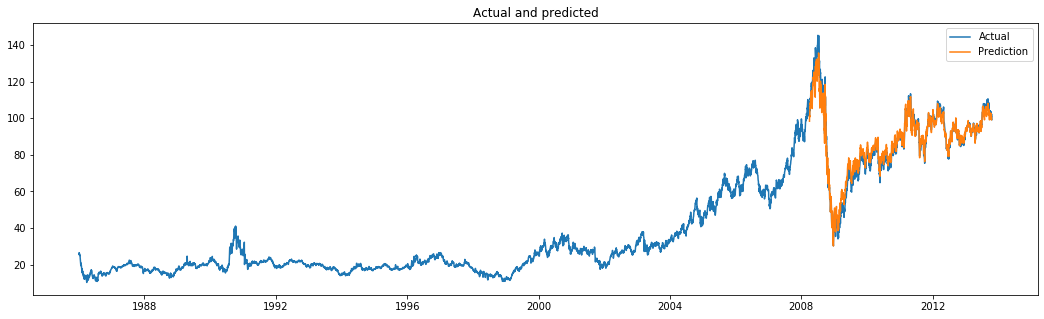

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / true)

pred = lstm_model.predict(trim_dataset(x_test,BATCH_SIZE), batch_size=BATCH_SIZE)
predicted = pred
Date_test=trim_dataset(data2['2008-4-1':'2013-10-21'].index,BATCH_SIZE)
Date_test=pd.to_datetime(Date_test.date)[-len(pred):]
original = trim_dataset(y_test,BATCH_SIZE)
# error = mean_squared_error(original, predicted)
# print("Error is", error, original.shape, predicted.shape)
invert_pred=min_max_scaler.inverse_transform(pred)
original=min_max_scaler.inverse_transform(original.reshape(-1,1))
rmse = mean_squared_error(original, invert_pred)**0.5
mape=MAPE(original,invert_pred)
print("RMSE", rmse)
print("MAPE", mape)
plt.figure(figsize=(18,5))
plt.title('Actual and predicted')
plt.plot(data2['1986-1-2':'2013-10-21'].index,data2['1986-1-2':'2013-10-21'], label = 'Original data')
plt.plot(Date_test,invert_pred, label = 'Predicted data')
plt.legend(['Actual', 'Prediction'],loc='best')
plt.show()